# 2 - Introductory Example: Ground Irradiance Analysis for AgriPV

This jupyter journal will walk us through the creation of the most basic fixed-tilt simulation possible with bifacialvf.
We will simulate a 1-up landscape system over a grass albedo and look at the ground irradiance from the start of 1 row to the other.


In [1]:
from pathlib import Path
import os
import bifacialvf
import matplotlib.pyplot as plt

# IO Files
testfolder = Path().resolve().parent.parent / 'bifacialvf' / 'TEMP' / 'Tutorial_01'
if not os.path.exists(testfolder):
    os.makedirs(testfolder)

In [2]:
plt.rcParams['timezone'] = 'Etc/GMT+7'
font = {'family' : 'DejaVu Sans',
'weight' : 'bold',
'size'   : 22}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = (12, 5)

In [3]:
writefiletitle = os.path.join(testfolder, 'Results_Tutorial2.csv')

# Variables
lat = 39.75555              # Golden CO, Coords.
lon = -105.2211             # Golden CO, Coords.
tilt = 10                   # PV tilt (deg)
sazm = 180                  # PV Azimuth(deg) or tracker axis direction
albedo = None               # Calculated in previous section from SRRL data. Value is 0.28 up to 11/18/19o
hub_height=1.5/2            #1.5m / 2m collector width
pitch = 2/0.35/2              # 1 / 0.35 where 0.35 is gcr --- row to row spacing in normalized panel lengths. 
rowType = "interior"        # RowType(first interior last single)
transFactor = 0             # TransmissionFactor(open area fraction)
sensorsy = 12                # sensorsy(# hor rows in panel)   <--> THIS ASSUMES LANDSCAPE ORIENTATION 
PVfrontSurface = "glass"    # PVfrontSurface(glass or ARglass)
PVbackSurface = "glass"     # PVbackSurface(glass or ARglass)
agriPV = True

 # Calculate PV Output Through Various Methods    
# calculateBilInterpol = False   # Only works with landscape at the moment.
# calculatePVMismatch = False
# portraitorlandscape='portrait'   # portrait or landscape
# cellsnum = 72
# bififactor = 1.0

# Tracking instructions
tracking=True
backtrack=True
limit_angle = 65

# Download and Read input
TMYtoread=bifacialvf.getEPW(lat=lat,lon=lon, path = testfolder)
myTMY3, meta = bifacialvf.readInputTMY(TMYtoread)
deltastyle = 'TMY3'
#myTMY3 = myTMY3.iloc[0:24].copy()  # Simulate just the first 24 hours of the data file for speed on this example

bifacialvf.simulate(myTMY3, meta, writefiletitle=writefiletitle, 
         tilt=tilt, sazm=sazm, pitch=pitch, hub_height=hub_height, 
         rowType=rowType, transFactor=transFactor, sensorsy=sensorsy, 
         PVfrontSurface=PVfrontSurface, PVbackSurface=PVbackSurface, 
         albedo=albedo, tracking=tracking, backtrack=backtrack, 
         limit_angle=limit_angle, deltastyle=deltastyle, agriPV=agriPV)

#Load the results from the resultfile
from bifacialvf import loadVFresults
(data, metadata) = loadVFresults(writefiletitle)

path = C:\Users\sayala\Documents\GitHub\bifacialvf\bifacialvf\TEMP\Tutorial_01
Getting weather file: USA_CO_Golden-NREL.724666_TMY3.epw
 ... OK!
Calculating Sun position with a delta of -30 mins. i.e. 12 is 11:30 sunpos
Using albedo from TMY3 file.
Note that at the moment, no validation check is done in the albedo data, so we assume it's correct and valid.

 
********* 
Running Simulation for TMY3: 
Location:   Denver Centennial  Golden   Nr
Lat:  39.74  Long:  -105.18  Tz  -7.0
Parameters: tilt:  0   Sazm:  180     Hub_Height :  0.75   Pitch:  2.857142857142857   Row type:  interior   Albedo:  None
Saving into C:\Users\sayala\Documents\GitHub\bifacialvf\bifacialvf\TEMP\Tutorial_01\Results_Tutorial2.csv
 
 
Distance between rows for no shading on Dec 21 at 9 am solar time =  0.0
Actual distance between rows =  1.8571428571428572
 
 ***** IMPORTANT --> THIS SIMULATION Has Tracking Activated
Backtracking Option is set to:  True
Saving Ground Irradiance Values for AgriPV Analysis. 


100%|█████████████████████████████████████████████████████████████████████████████| 8760/8760 [01:25<00:00, 101.98it/s]


Finished


In [4]:
from bifacialvf import loadVFresults
(data, metadata) = loadVFresults(writefiletitle)

# 5. Analyze the results from the resultfile


In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
data.set_index(pd.to_datetime(data['date']), inplace=True, drop=True)
data.index = data.index.map(lambda t: t.replace(year=2021))   # Chagning to be the same year
groundIrrads = data['Ground Irradiance Values'].str.strip('[]').str.split(' ', expand=True).astype(float)

In [7]:
df = groundIrrads.groupby([pd.Grouper(freq='M')]).sum().T
# I'm sure there's a fancier way to do this but hey, this works.
df.rename(columns={ df.columns[0]: "Jan", df.columns[1]: "Feb",df.columns[2]: "Mar", df.columns[3]: "Apr",
                   df.columns[4]: "May",df.columns[5]: "June",df.columns[6]: "July",df.columns[7]: "Aug",
                   df.columns[8]: "Sept",df.columns[9]: "Oct",df.columns[10]: "Nov",df.columns[11]: "Dec"    }, inplace = True)

Text(0, 0.5, 'Cumulative Insolation for the month [kWh/m2]')

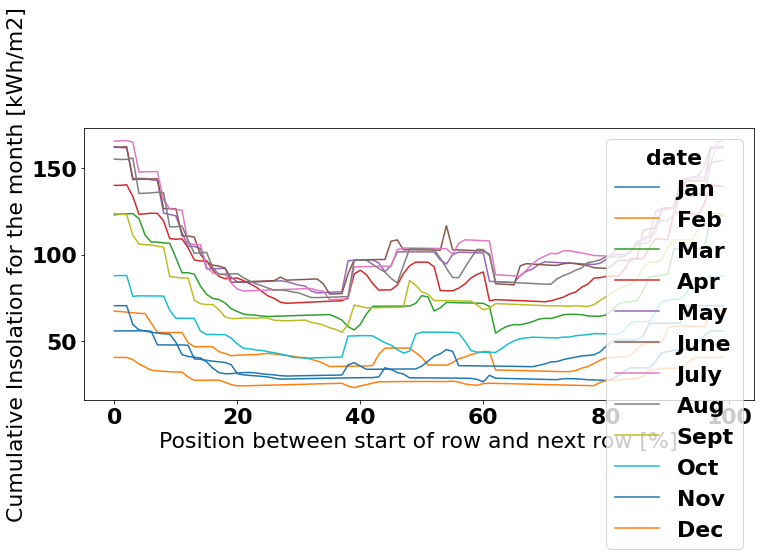

In [8]:
fig = (df/1000).plot()
fig.set_xlabel('Position between start of row and next row [%]')
fig.set_ylabel('Cumulative Insolation for the month [kWh/m2]')

In [9]:
monthlyGHI = pd.DataFrame(data['ghi'].groupby([pd.Grouper(freq='M')]).sum())

In [10]:
monthlyGHI['Month'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']
monthlyGHI.set_index(monthlyGHI['Month'], inplace=True)
monthlyGHI = monthlyGHI.drop(columns='Month')

In [11]:
df_norm = df.T
df_norm = df_norm.div(monthlyGHI['ghi'], axis=0)
df_norm = df_norm.T

Text(0, 0.5, 'Normalized Insolation for the month/GHI')

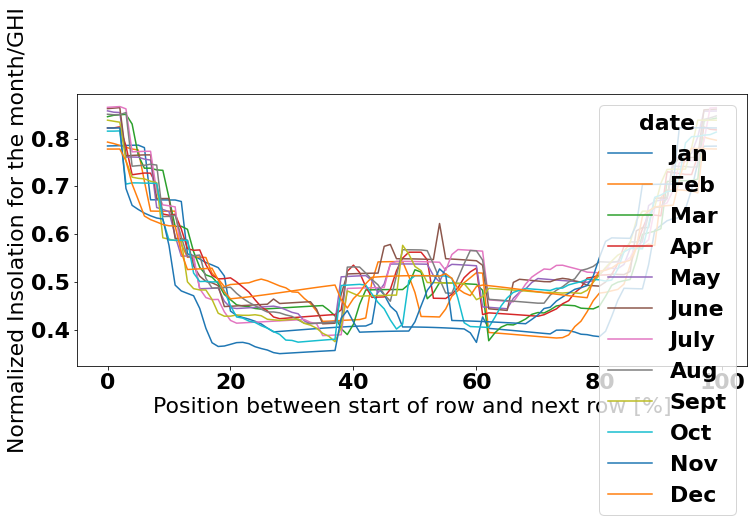

In [12]:
fig = (df_norm).plot()
fig.set_xlabel('Position between start of row and next row [%]')
fig.set_ylabel('Normalized Insolation for the month/GHI')